<a href="https://colab.research.google.com/github/estoymukundjha/Titanic---Machine-Learning-from-Disaster/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import numpy as np
import pandas as pd 

# for eda & visualizations
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
sns.set(style='white', context='notebook', palette='deep')

#algoritms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
#evaluation

from sklearn.metrics import accuracy_score



import warnings
warnings.filterwarnings('ignore')


#Import Data

In [29]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')
PAS = list(test_df.PassengerId)


In [30]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [31]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [32]:
train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [33]:
display(train_df.describe(include= ['O']))
display(test_df.describe(include= ['O']))

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Fynney, Mr. Joseph J",male,347082,C23 C25 C27,S
freq,1,577,7,4,644


,Name,Sex,Ticket,Cabin,Embarked
count,418,418,418,91,418
unique,418,2,363,76,3
top,"Lockyer, Mr. Edward",male,PC 17608,B57 B59 B63 B66,S
freq,1,266,5,3,270


In [34]:
display(train_df.isna().sum())
display(test_df.isna().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

##Handling missing values

In [35]:
#Replacing the null values of age with the median of age and gender 
train_df['Age'][train_df['Sex']=='female'] = train_df['Age'][train_df['Sex']=='female'].fillna(train_df['Age'][train_df['Sex']=='female'].median())
train_df['Age'][train_df['Sex']=='male'] = train_df['Age'][train_df['Sex']=='male'].fillna(train_df['Age'][train_df['Sex']=='male'].median())

test_df['Age'][test_df['Sex']=='female'] = test_df['Age'][test_df['Sex']=='female'].fillna(test_df['Age'][test_df['Sex']=='female'].median())
test_df['Age'][test_df['Sex']=='male'] = test_df['Age'][test_df['Sex']=='male'].fillna(test_df['Age'][test_df['Sex']=='male'].median())

In [36]:
#Replacing value the null values of embarked and fare
train_df['Embarked'].fillna(train_df['Embarked'].dropna().mode()[0], inplace= True)
test_df['Fare'].replace(np.nan, np.mean(test_df['Fare']), inplace= True)


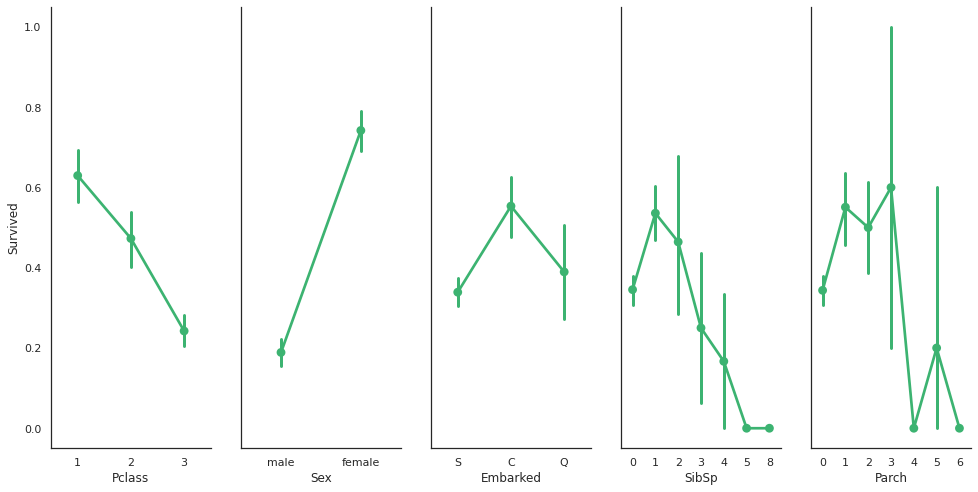

In [37]:
#Looking at the percentage of survival accross categorical data using pointplot
g = sns.PairGrid(train_df, y_vars= 'Survived',
                 x_vars=['Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch'],
                 height= 7, aspect= 0.4)

g.map(sns.pointplot, scale= 1, errwidth= 3, color= 'mediumseagreen')

In [38]:
#Combining test and train data to feature engineer to create family column which includes the Parch and SibSp columns
combined_df = [train_df, test_df]
for i in combined_df:
    i['family'] = i['Parch'] + i['SibSp'] + 1

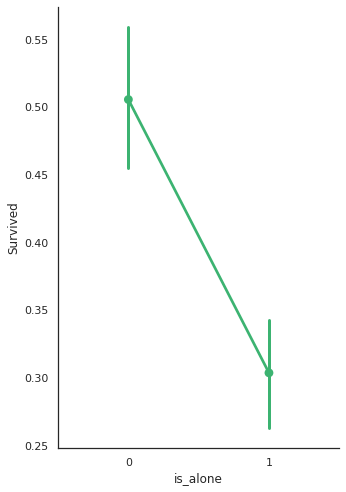

In [39]:
#Creating is_alone column and displying the results using a pointplot
for i in combined_df:
    i['is_alone'] = 0
    i.loc[i['family'] == 1, 'is_alone'] = 1

g = sns.PairGrid(train_df, y_vars= 'Survived',
                 x_vars= 'is_alone',
                 height= 7, aspect= 0.7)

g.map(sns.pointplot, scale= 1, errwidth= 3, color= 'mediumseagreen')


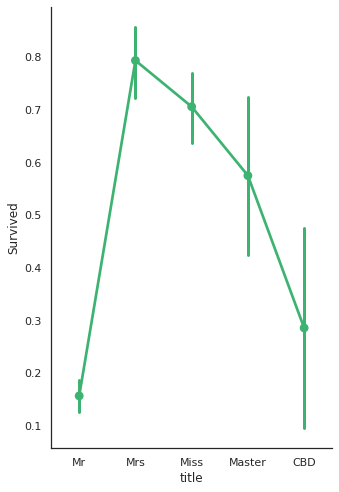

In [40]:
#Extrating the title out of names to create the title column and displaying the results using a pointplot
for i in combined_df:
    i['title'] = i.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

for i in combined_df:
    i['title'] = i['title'].replace(['Jonkheer', 'Dona',
 	'Dr', 'Don', 'Major', 'Col', 'Sir', 'Capt', 'Rev'], 'CBD')
    
    i['title'] = i['title'].replace(['Mlle', 'Lady', 'Countess'], 'Miss')
    i['title'] = i['title'].replace('Ms', 'Miss')
    i['title'] = i['title'].replace('Mme', 'Mrs')

g = sns.PairGrid(train_df, y_vars= 'Survived',
                 x_vars= 'title',
                 height= 7, aspect= .7)
g.map(sns.pointplot, scale= 1, errwidth= 3, color= 'mediumseagreen')

In [41]:
#Coverting categorical values into labels using sklearn's LabelEncoder
from sklearn.preprocessing import LabelEncoder
label_sex = LabelEncoder()
label_embark = LabelEncoder()
label_title = LabelEncoder()
label_title = LabelEncoder()

for i in combined_df:
    i['Sex'] = label_sex.fit_transform(i['Sex'])


for i in combined_df:
    i['Embarked'] = label_embark.fit_transform(i['Embarked'])


for i in combined_df:
    i['title'] = label_title.fit_transform(i['title'])

In [42]:
#Dropping columns which will not be used in building our model
passenger_id = test_df['PassengerId']
for i in combined_df:
    i.drop(['Name', 'PassengerId', 'Ticket', 'Cabin'], axis= 1, inplace= True)
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,family,is_alone,title
0,0,3,1,22.0,1,0,7.2500,2,2,0,3
1,1,1,0,38.0,1,0,71.2833,0,2,0,4
2,1,3,0,26.0,0,0,7.9250,2,1,1,2
3,1,1,0,35.0,1,0,53.1000,2,2,0,4
4,0,3,1,35.0,0,0,8.0500,2,1,1,3


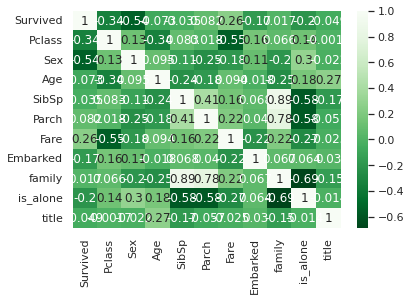

In [43]:
#Looking at the correlation of the data
corr = train_df.corr()
sns.heatmap(corr, cmap= 'Greens_r', annot = True)

In [44]:
#Standardising the Fare column using sklearn's StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_fare_train_df = train_df['Fare'].values.reshape(-1, 1)
fare_scaled_train_df = scaler.fit_transform(data_fare_train_df)
train_df['scaled_fare'] = fare_scaled_train_df

data_fare_test_df = test_df['Fare'].values.reshape(-1, 1)
fare_scaled_test_df = scaler.fit_transform(data_fare_test_df)
test_df['scaled_fare'] = fare_scaled_test_df
display(train_df.isna().sum())

Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
family         0
is_alone       0
title          0
scaled_fare    0
dtype: int64

In [45]:
#Dropping columns which have were used to feature engineer new columns
for i in combined_df:
    i.drop(['Fare', 'SibSp', 'Parch', 'family'], axis= 1, inplace= True)

In [46]:
#Standardising the Age column using sklearn's StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_age_train_df = train_df['Age'].values.reshape(-1, 1)
age_scaled_train_df = scaler.fit_transform(data_age_train_df)
train_df['Age'] = age_scaled_train_df

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_age_test_df = test_df['Age'].values.reshape(-1, 1)
age_scaled_test_df = scaler.fit_transform(data_age_test_df)
test_df['Age'] = age_scaled_test_df

In [47]:
#Splitting the data into target and predictor variables
X = train_df.drop('Survived', axis= 1)
Y = train_df['Survived'].values

In [48]:
#Splitting the data into train and test data
from sklearn.model_selection import train_test_split
x_train_df,x_test_df,y_train_df,y_test_df = train_test_split(X, Y,test_size= 0.3 , random_state= 2)

In [49]:
#Finding the right parameters for RandomForestClssifier using GridSearchCV and fitting the data
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

param_grid = {'n_estimators': [100, 200, 300, 400, 500],
             'min_samples_leaf': np.arange(0.1, 1)}
rf = RandomForestClassifier()
grid = GridSearchCV(estimator= rf, param_grid= param_grid, scoring= 'accuracy', cv= 10)


In [50]:
grid.fit(X, Y)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

In [51]:
#Predicting the data and getting the accuracy score
pred = grid.predict(test_df)
gender_df = pd.read_csv('/content/gender_submission.csv' , usecols= ['Survived'])
display(accuracy_score(gender_df, pred))
print(classification_report(gender_df, pred))

0.8516746411483254

              precision    recall  f1-score   support

           0       0.82      0.98      0.89       266
           1       0.96      0.62      0.75       152

    accuracy                           0.85       418
   macro avg       0.89      0.80      0.82       418
weighted avg       0.87      0.85      0.84       418

